# Introducción

Este cuadernillo contiene el código y los comentarios. Está dividido en 3 partes, en la primera se diseña y se entrena la DCGAN, en la segunda se le añade experience replay y en la tercera se diseña una DCGAN condicional.

Los modelos e imágenes generados en cada una de las tres partes se han adjuntado en las carpetas models e images respectivamente. De esta manera no hay que volver a ejecutar el código, lo que llevaría varias horas debido al entrenamiento.

El entrenamiento de los modelos se realizó usando GPUs en Google Colabs y duró varias horas

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot
from datetime import datetime

In [3]:
# Descarga los datos
(train_X, train_y), (_, _)  = keras.datasets.cifar10.load_data()
# convert from unsigned ints to floats
X = train_X.astype('float32')
# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5

# 1.Construcción y entrenamiento DCGAN

En esta primera parte se diseña la GAN, se entrena y se muestran las imágenes que genera una vez entrenada. Para diseñar las GAn se han seguido las directrices dadas en el capítulo 17 del libro "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition" aunque se han hecho algunos cambios que se comentan a continuación.

Siguiendo las recomendaciones encontradas en https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/ se ha usado la función de activación LeakyRelu en lugar de Selu, y se ha usado el optimizer Adam con un learning rate de 0.0002 y un beta_1 de 0.5.

### Construye el generador y el discriminador

In [4]:
codings_size = 100

# Diseño de la red generadora
generator = keras.models.Sequential([
    keras.layers.Dense(256 * 4 * 4, input_shape=[codings_size]),
    keras.layers.Reshape([4, 4, 256]),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2DTranspose(128, kernel_size=4, padding="same", input_shape = [codings_size],
                                 activation=keras.layers.LeakyReLU(0.2), strides=2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2DTranspose(128, kernel_size=4, padding="same", input_shape = [codings_size],
                                 activation=keras.layers.LeakyReLU(0.2), strides=2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2DTranspose(128, kernel_size=4, padding="same", input_shape = [codings_size],
                                 activation=keras.layers.LeakyReLU(0.2), strides=2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2DTranspose(3, kernel_size=3, padding="same", input_shape = [codings_size],activation="tanh"),
])

# Diseño de la red discriminadora
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[32, 32, 3]),
    
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[32, 32, 3],
                       strides=2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[32, 32, 3],
                       strides=2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[32, 32, 3],
                       strides=2),
    keras.layers.BatchNormalization(),    
    
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])


gan = keras.models.Sequential([generator, discriminator])

### Compila el modelo

In [5]:
opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt)
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer=opt)

In [6]:
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

### Función que guarda y representa las imágenes

In [7]:
def create_plot(generator,n = 4, save = False, plot = True, file_name = 'image'):
    noise = tf.random.normal(shape=[n*n, codings_size])
    generated_images = generator(noise)
    
    # Pasa de [-1,1] a [0,1]
    generated_images = (generated_images + 1) / 2.0
    
    for i in range(n*n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(generated_images[i, :, :])
        
    if save:
        pyplot.savefig(file_name)
    
    if plot:
        pyplot.show()   

### Crea las carpetas para guardar los modelos y las imágenes generadas

In [8]:
import os
if not os.path.exists('models'):
    os.makedirs('models')
    
if not os.path.exists('images'):
    os.makedirs('images')

### Entrena el modelo

Durante el entrenamiento se guardan algunas imágenes generadas cada 20 epochs y el modelo que las ha generado. Esto se hace para ver si realmente la GAN está mejorando con el entrenamiento, o si hay algún punto en el que empieza a empeorar, en cuyo caso se puede utilizar un modelo de una epoch anterior.

 20%|█▉        | 39/200 [30:28<2:02:49, 45.77s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 200/200 [2:33:51<00:00, 46.16s/it]


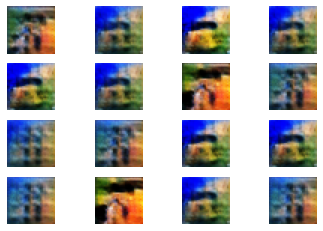

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=1):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(n_epochs)):
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        # Save the model and images sometimes
        if (epoch+1) % 20 == 0:
            filename = 'models/generator_model_%03d.h5' % (epoch+1)
            generator.save(filename)
            create_plot(generator, 4, True, False, 'images/images_%03d' % (epoch+1))
        
train_gan(gan, dataset, batch_size, codings_size, n_epochs = 200)

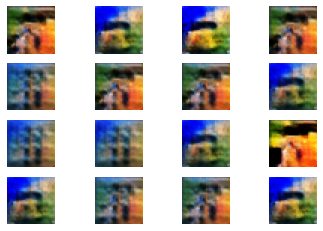

In [10]:
# Carga un modelo y genera imágenes con él
modelo = keras.models.load_model('models/generator_model_200.h5', custom_objects={'LeakyReLU': keras.layers.LeakyReLU(0.2)})
create_plot(modelo,4)

Después de 200 epochs las imágenes generadas no son lo suficientemente realistas para engañar a una persona, aunque por lo menos se ha conseguido generar imágenes que no son ruido aleatorio. El hecho de que todas las imágenes se parezcan tanto indica que el generador ha encontrado un punto débil en el discriminador y que lo está explotando, lo que reduce mucho la diversidad en las imágenes.

# 2. Experience Replay

En este apartado se añade la experience replay. El generador y el discriminador van a ser los mismos que en el apartado anterior, solo se va a modificar el entrenamiento para que algunas de las imágenes generadas se almacenen en una lista, y cuando la lista tenga el mismo tamaño que el batch se usan para entrenar el discriminador. Una vez usadas esas imágenes se descartan y el proceso empieza de nuevo.

 20%|█▉        | 39/200 [30:02<2:01:55, 45.44s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 200/200 [2:31:38<00:00, 45.49s/it]


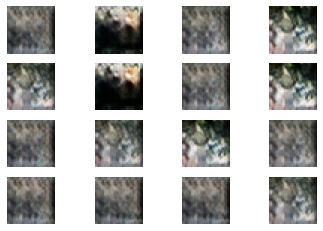

In [ ]:
def train_replay_gan(gan, dataset, batch_size, codings_size, n_epochs=1):
    generator, discriminator = gan.layers
    
    # Para el experience replay
    exp_replay = []
    
    for epoch in tqdm(range(n_epochs)):
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)   
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # Almacena una de las imágenes del batch para el experience replay
            exp_replay.append(generated_images[0])
            
            # Cuando haya suficientes imágenes almacenadas se hace el exp replay
            if len(exp_replay) == batch_size:
                                
                generated_images = np.array(exp_replay)
                
                # Entrena al discriminator con las imágenes almacenadas
                discriminator.train_on_batch(generated_images, tf.constant([[0.]] * batch_size))
                
                # Borra las imágenes almacenadas
                exp_replay = []
                
            
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        # Save the model and images sometimes
        if (epoch+1) % 20 == 0:
            filename = 'models/replay_model_%03d.h5' % (epoch+1)
            generator.save(filename)
            create_plot(generator, 4, True, False, 'images/images_with_replay_%03d' % (epoch+1))
        
train_replay_gan(gan, dataset, batch_size, codings_size, n_epochs = 200)

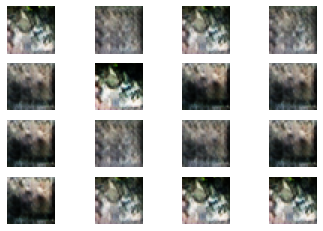

In [11]:
modelo_replay = keras.models.load_model('models/replay_model_200.h5', custom_objects={'LeakyReLU': keras.layers.LeakyReLU(0.2)})
create_plot(modelo_replay,4)

Las imágenes son algo mejores que en el apartado anterior, pero siguen siendo poco realistas y muy parecidas entre sí.

# 3. Conditional GAN

En este último apartado se diseña una GAN condicional que también tiene experience replay. Pues que para este tipo de red neuronal hace falta usar la API funcional de keras (al contrario que en los anteriores apartados) se ha usado el código encontrado en https://github.com/utkd/gans/blob/master/cifar10cgan.ipynb y se ha modificado para que la red neronal tenga la misma forma que en los anteriores apartados.

In [12]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

### Crea el generador

In [13]:
def get_generator(input_layer, condition_layer):

    merged_input = Concatenate()([input_layer, condition_layer])
  
    hid = Dense(256 * 4 * 4, activation='relu')(merged_input)    
    hid = BatchNormalization()(hid)
    hid = Reshape((4, 4, 256))(hid)

    hid = Conv2DTranspose(128, kernel_size=4, strides=2,padding='same')(hid)
    hid = BatchNormalization()(hid)    
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2DTranspose(128, kernel_size=4, strides=2,padding='same')(hid)
    hid = BatchNormalization()(hid)    
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2DTranspose(128, kernel_size=4, strides=2,padding='same')(hid)
    hid = BatchNormalization()(hid)    
    hid = LeakyReLU(alpha=0.2)(hid)    

    hid = Conv2DTranspose(3, kernel_size=3, strides=1, padding="same")(hid)
    out = Activation("tanh")(hid)

    model = Model(inputs=[input_layer, condition_layer], outputs=out)
    model.summary()
  
    return model, out

### Crea el discriminador

In [14]:
def get_discriminator(input_layer, condition_layer):
    hid = Conv2D(64, kernel_size=3, strides=1, padding='same')(input_layer)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(128, kernel_size=3, strides=2, padding='same')(hid)
    hid = BatchNormalization()(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(128, kernel_size=3, strides=2, padding='same')(hid)
    hid = BatchNormalization()(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(256, kernel_size=3, strides=2, padding='same')(hid)
    hid = BatchNormalization()(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Flatten()(hid)
  
    merged_layer = Concatenate()([hid, condition_layer])
    hid = Dropout(0.4)(hid)
    out = Dense(1, activation='sigmoid')(hid)

    model = Model(inputs=[input_layer, condition_layer], outputs=out)

    model.summary()

    return model, out

### Funciones para codificar y generar etiquetas y para generar ruido

In [15]:
from keras.preprocessing import image

def one_hot_encode(y):
    z = np.zeros((len(y), 10))
    idx = np.arange(len(y))
    z[idx, y] = 1
    return z


def generate_random_labels(n):
    y = np.random.choice(10, n)
    y = one_hot_encode(y)
    return y

def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

### Función que genera y guarda imágenes

In [16]:
def save_samples(filename):
    fig, axs = plt.subplots(5, 6, figsize=(10,6))
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
  
    for classlabel in range(10):
        row = int(classlabel / 2)
        coloffset = (classlabel % 2) * 3
        lbls = one_hot_encode([classlabel] * 3)
        noise = generate_noise(3, 100)
        gen_imgs = generator.predict([noise, lbls])

    for i in range(3):
        # Dont scale the images back, let keras handle it
        img = image.array_to_img(gen_imgs[i], scale=True)
        axs[row,i+coloffset].imshow(img)
        axs[row,i+coloffset].axis('off')
        if i ==1:
            axs[row,i+coloffset].set_title(tags[classlabel])
    plt.savefig(filename)

### Monta la GAN

In [17]:
# GAN creation
img_input = Input(shape=(32,32,3))
disc_condition_input = Input(shape=(10,))

discriminator, disc_out = get_discriminator(img_input, disc_condition_input)
discriminator.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
gen_condition_input = Input(shape=(10,))
generator, gen_out = get_generator(noise_input, gen_condition_input)

gan_input = Input(shape=(100,))
x = generator([gan_input, gen_condition_input])
gan_out = discriminator([x, disc_condition_input])
gan = Model([gan_input, gen_condition_input, disc_condition_input], gan_out)
gan.summary()

gan.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 32, 32, 64)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 16, 16, 128)  73856       leaky_re_lu_10[0][0]             
_______________________________________________________________________________________

### Prepara los datos

In [18]:
BATCH_SIZE = 128

# Normalize data
X_train = X

# 1hot encode labels
y_train = one_hot_encode(train_y[:,0])

print ("Training shape: {}, {}".format(X_train.shape, y_train.shape))
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

print ("Num batches: {}".format(num_batches))

Training shape: (50000, 32, 32, 3), (50000, 10)
Num batches: 390


### Entrena la GAN

In [ ]:
import os
if not os.path.exists('models'):
    os.makedirs('models')
    
if not os.path.exists('images'):
    os.makedirs('images')

# Array to store samples for experience replay
exp_replay = []

N_EPOCHS = 200
for epoch in range(N_EPOCHS):

    cum_d_loss = 0.
    cum_g_loss = 0.
  
    for batch_idx in range(num_batches):
        # Get the next set of real images to be used in this iteration
        images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
        labels = y_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

        noise_data = generate_noise(BATCH_SIZE, 100)
        random_labels = generate_random_labels(BATCH_SIZE)
        # We use same labels for generated images as in the real training batch
        generated_images = generator.predict([noise_data, labels])

        # Train on soft targets (add noise to targets as well)
        noise_prop = 0.05 # Randomly flip 5% of targets
    
        # Prepare labels for real data
        true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
        flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
        true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
        # Train discriminator on real data
        d_loss_true = discriminator.train_on_batch([images, labels], true_labels)

        # Prepare labels for generated data
        gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
        flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
        gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
        # Train discriminator on generated data
        d_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
      
        # Store a random point for experience replay
        r_idx = np.random.randint(BATCH_SIZE)
        exp_replay.append([generated_images[r_idx], labels[r_idx], gene_labels[r_idx]])
    
        # If we have enough points, do experience replay
        if len(exp_replay) == BATCH_SIZE:
            generated_images = np.array([p[0] for p in exp_replay])
            labels = np.array([p[1] for p in exp_replay])
            gene_labels = np.array([p[2] for p in exp_replay])
            expprep_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
            exp_replay = []
    
        d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
        cum_d_loss += d_loss

        # Train generator
        noise_data = generate_noise(BATCH_SIZE, 100)
        random_labels = generate_random_labels(BATCH_SIZE)
        g_loss = gan.train_on_batch([noise_data, random_labels, random_labels], np.zeros((BATCH_SIZE, 1)))
        cum_g_loss += g_loss

        if batch_idx % 500 == 0:
            print(batch_idx, d_loss_true[0], d_loss_gene[0], g_loss, "Cumu:", cum_d_loss[0]/(batch_idx+1), cum_g_loss/(batch_idx+1))

    print('\tEpoch: {}, Generator Loss: {}, Discriminator Loss: {}\n\n'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
    
    if (epoch+1) % 20 == 0:
        save_samples('images/conditional_images_%03d' % (epoch+1))
        generator.save('models/conditional_models_%03d.h5' % (epoch+1))

0 0.31484299898147583 0.3143978714942932 0.43994027376174927 Cumu: 0.3146204352378845 0.43994027376174927
	Epoch: 1, Generator Loss: 0.36338399071723987, Discriminator Loss: [0.30689235 0.        ]


0 0.3021184206008911 0.30362412333488464 0.30680331587791443 Cumu: 0.3028712719678879 0.30680331587791443
	Epoch: 2, Generator Loss: 0.43330219044135165, Discriminator Loss: [0.30699927 0.        ]


0 0.31212788820266724 0.31448787450790405 0.4021014869213104 Cumu: 0.31330788135528564 0.4021014869213104
	Epoch: 3, Generator Loss: 0.4161316255728404, Discriminator Loss: [0.30731372 0.        ]


0 0.3068893551826477 0.2936159074306488 0.5819012522697449 Cumu: 0.30025263130664825 0.5819012522697449
	Epoch: 4, Generator Loss: 0.47225807928122004, Discriminator Loss: [0.30700226 0.        ]


0 0.31646090745925903 0.30501872301101685 0.4030216932296753 Cumu: 0.31073981523513794 0.4030216932296753
	Epoch: 5, Generator Loss: 0.3949002758050576, Discriminator Loss: [0.30742919 0.        ]


0 0.

### Genera imágenes para cada clase

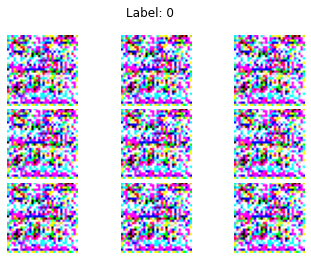

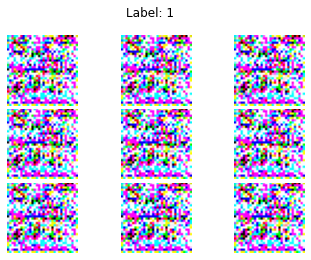

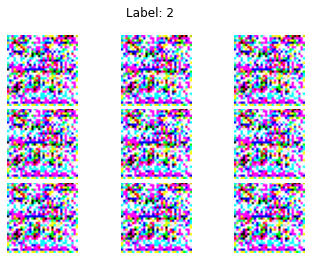

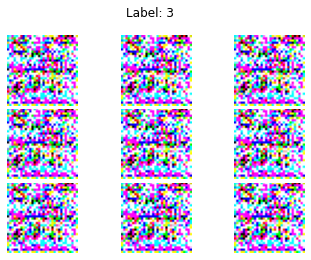

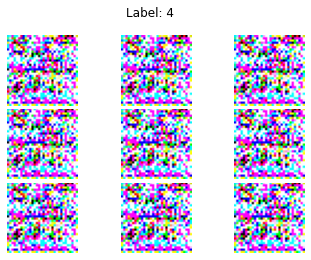

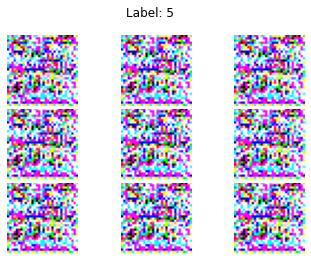

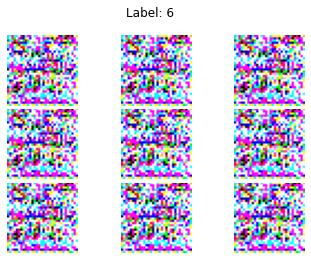

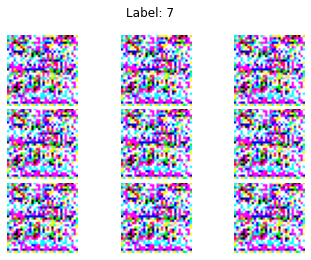

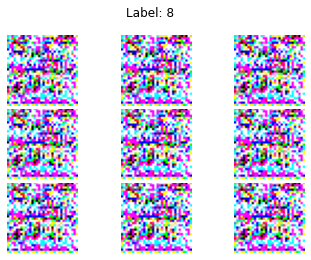

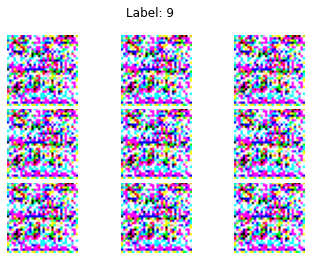

In [19]:
for classlabel in range(10):
    lbls = one_hot_encode([classlabel] * 9)
    noise = generate_noise(9, 100)
    generator = keras.models.load_model('models/conditional_models_200.h5', custom_objects={'LeakyReLU': keras.layers.LeakyReLU(0.2)})
    gen_imgs = generator.predict([noise, lbls])

    fig, axs = plt.subplots(3, 3)
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    count = 0
    for i in range(3):
        for j in range(3):
            # Dont scale the images back, let keras handle it   
            img = image.array_to_img(gen_imgs[count], scale=True)
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            plt.suptitle('Label: ' + str(classlabel))
            count += 1
    plt.show()
    plt.close()

En el caso de la DCGAN condicional no se ha conseguido producir más que ruido a lo largo de las 200 epochs de entrenamiento. Esto puede ser debido a que se han usado las mismas capas generadoras y discriminadoras que en los apartados anteriores y este modelo al ser condicional necesitaba otro diseño. 